# CNN Cancer Detection Kaggle Mini-Project

#### Preparation
Below the required modules are loaded, the image names and labels are read, and a list of computing resources available is printed. 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from tensorflow.python.keras.saving.saved_model.serialized_attributes import metrics
import tensorflow as tf
import os
# import tifffile
import cv2

if os.path.exists(r'C:\Users\nikok\Documents'):
    raw_data_path = r'C:\Users\nikok\Documents\CNN Cancer Detection Kaggle Mini-Project'
else:
    raw_data_path = r'C:\Users\kuusnin\tempwork\temp\CNN Cancer Detection Kaggle Mini-Project'
train_labels = pd.read_csv(os.path.join(raw_data_path, 'train_labels.csv'))
train_labels.sort_values(by='id', inplace=True)


In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']


## Brief description of the problem and data 
*Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.* 

### Problem description
The objective is to "identify metastatic tissue in histopathologic scans of lymph node sections." Images are from small image patches taken from larger image scans. Target is to identify if 32x32 region in the center of the image contains at least one pixel of tumor. 

### Data
The training set has 220k images and testing set has 57k images. The train/test split is 80/20. Number of testing images matches the number of labels in the label csv file. 

Picture size is 96x96 (total number of pixels 9216) and three channels for RGB. The values in each channel take values between 0 and 255 ($2^8$, 8 bits).

The code below checks the data and also reads each training image to make sure there are no errors. 


In [3]:
def read_pic(file, method='keras'):
    if method == 'keras':
        img = keras.utils.load_img(file)
        x = keras.utils.img_to_array(img)
    return img, x

train_files = os.listdir(os.path.join(raw_data_path, 'train'))
test_files = os.listdir(os.path.join(raw_data_path, 'test'))
train_split = len(train_files)/(len(train_files)+len(test_files))

print('Number of training labels:', len(train_labels))
print('Number of training images:', len(train_files), '(' + str(round(train_split*100))+'%)')
print('Number of testing images:', len(test_files), '(' + str(round((1-train_split)*100))+'%)')


print('\nStructure of training labels dataframe:')
print(train_labels.head())
print('Five first training image names:')
print('\t'+'\n\t'.join(train_files[0:5]))

print()
img, X = read_pic(os.path.join(raw_data_path, 'train', train_files[0]))
img_size = X.shape
print('Image size:', X.shape[0:2])
print('Number of image channels', X.shape[-1])
print('Smallest and largest number in a picture:', np.min(X), np.max(X))

# Make sure that all the images can be read
# for f in train_files:
#     read_pic(os.path.join(raw_data_path, 'train',f))

Number of training labels: 220025
Number of training images: 220025 (79%)
Number of testing images: 57458 (21%)

Structure of training labels dataframe:
                                              id  label
151577  00001b2b5609af42ab0ab276dd4cd41c3e7745b5      1
16166   000020de2aa6193f4c160e398a8edea95b1da598      0
87832   00004aab08381d25d315384d646f5ce413ea24b1      0
69359   0000d563d5cfafc4e68acb7c9829258a298d9b6a      0
128953  0000da768d06b879e5754c43e2298ce48726f722      1
Five first training image names:
	00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
	000020de2aa6193f4c160e398a8edea95b1da598.tif
	00004aab08381d25d315384d646f5ce413ea24b1.tif
	0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif
	0000da768d06b879e5754c43e2298ce48726f722.tif

Image size: (96, 96)
Number of image channels 3
Smallest and largest number in a picture: 0.0 255.0


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
*Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?*

Below the data set is check for duplicates and the balance of positive and negative labels is checked (41% vs 59%). Also a few example images are shown from both categories. 

Any duplicated entries in labels: False
Do the ids in label csv match the image file names: True
Number of positive labels: 89117 (41%)
Number of negative labels: 130908 (59%)


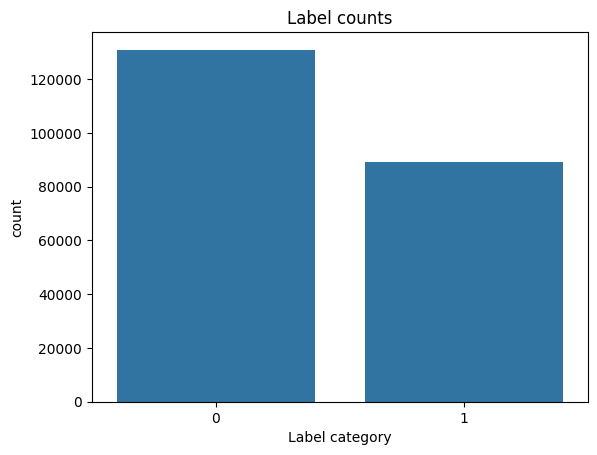

PIL.TiffImagePlugin.TiffImageFile

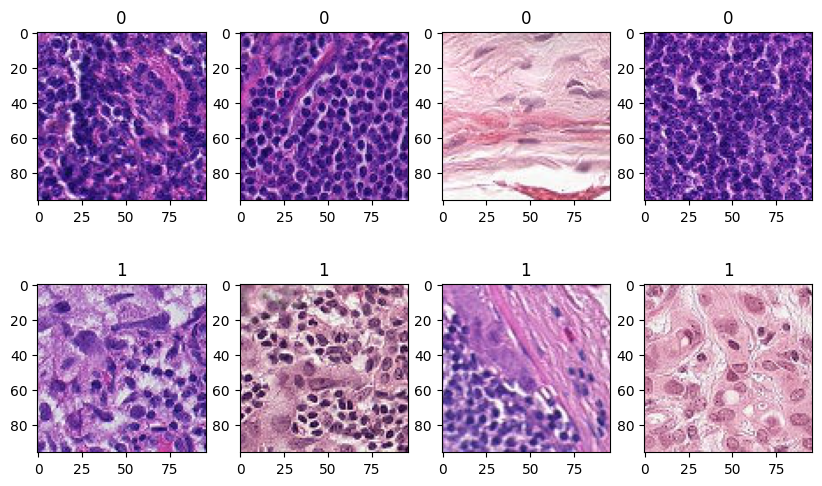

In [26]:
print('Any duplicated entries in labels:', np.any(train_labels.duplicated()))
print('Do the ids in label csv match the image file names:', np.all((train_files) == (train_labels.id+'.tif')))

pos = np.sum(train_labels.label == 1)
neg = np.sum(train_labels.label == 0)
print('Number of positive labels:', pos, '(' + str(round(pos/(neg+pos)*100))+'%)')
print('Number of negative labels:', neg, '(' + str(round(neg/(neg+pos)*100))+'%)')

train_labels['Label category'] = train_labels.label.astype('category')

sns.countplot(x='Label category', data=train_labels)
plt.title('Label counts')
plt.show()

plt.figure(figsize=(10, 6))
files = np.random.choice(train_labels.id[train_labels.label==0], 4, replace=False)
files = np.append(files, np.random.choice(train_labels.id[train_labels.label==1], 4, replace=False))
files = files + '.tif'
for i, file in enumerate(files):
    ax = plt.subplot(2, 4, i + 1)
    img, X = read_pic(os.path.join(raw_data_path, 'train', file))
    i_lbl = np.where(train_labels.id+'.tif' == file)[0]
    plt.title((train_labels.label.iloc[i_lbl].values)[0])
    plt.imshow(img)
type(img)


## Create a dataset
Manual data flow has to be created for tif-images. 
### Data set building
https://www.tensorflow.org/tutorials/load_data/images

In [9]:
import pathlib
# import glob
# import rasterio

data_dir = pathlib.Path(os.path.join(raw_data_path, 'train')).with_suffix('')
image_paths = [os.path.join(raw_data_path, 'train', item) for item in os.listdir(os.path.join(raw_data_path, 'train'))]
class_names = ['0','1']

image_count = len(image_paths) 
print(image_count)

list_ds = tf.data.Dataset.list_files(str(data_dir/'*'), shuffle=False)
labels_ds = tf.data.Dataset.from_tensor_slices(train_labels.label.values)
list_ds = tf.data.Dataset.zip((list_ds, labels_ds))
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

for (f, g) in list_ds.take(5):
    print(f.numpy())
    cv2.imread(str(f.numpy()), cv2.IMREAD_UNCHANGED)

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

def decode_img(file_path):
  return cv2.imread(file_path.numpy().decode('utf-8'), cv2.IMREAD_UNCHANGED)  # Load TIFF image

def parse_tif(file_path, label):
    img = tf.py_function(decode_img, [file_path], tf.float32)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    label = tf.convert_to_tensor(label, dtype=tf.int64) 
    return img, label

# From: https://discuss.ai.google.dev/t/valueerror-as-list-is-not-defined-on-an-unknown-tensorshape/30815/5
def _fixup_shape(images, labels):
    images.set_shape((96,96,3))
    labels.set_shape([])
    return images, labels

val_ds = val_ds.map(parse_tif, num_parallel_calls=tf.data.AUTOTUNE)  # Not working

train_ds = train_ds.map(lambda x, y: tf.py_function(func=parse_tif, inp=[x, y], Tout=(tf.float32, tf.int64)), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(_fixup_shape) 
val_ds = val_ds.map(_fixup_shape) 

for image, label in val_ds.take(4):
  print("Val Image shape: ", image.numpy().shape)
  print("Val Label shape: ", label.numpy().shape)
  print("Val Label: ", label.numpy())

image, label = next(train_ds.as_numpy_iterator())
print("Train Image shape:", image.shape)
print("Train Label shape: ", label.shape)
print("Train Label:", label)

220025
b'C:\\Users\\kuusnin\\tempwork\\temp\\CNN Cancer Detection Kaggle Mini-Project\\train\\539ee23f3b5fa5ba21840de219ffbf2a82ca1d57.tif'
b'C:\\Users\\kuusnin\\tempwork\\temp\\CNN Cancer Detection Kaggle Mini-Project\\train\\457fec71be30ae07ea9d85a7f3efb9d500a4dfaa.tif'
b'C:\\Users\\kuusnin\\tempwork\\temp\\CNN Cancer Detection Kaggle Mini-Project\\train\\b3d9e81d50032415562cc5c809b9f9adedd0371a.tif'
b'C:\\Users\\kuusnin\\tempwork\\temp\\CNN Cancer Detection Kaggle Mini-Project\\train\\bc9dc7919faf650043195cd5c86bc3e85f5a5cee.tif'
b'C:\\Users\\kuusnin\\tempwork\\temp\\CNN Cancer Detection Kaggle Mini-Project\\train\\6508527abc93caafca21ca2d888a8dc8abb6b992.tif'
176020
44005
Val Image shape:  (96, 96, 3)
Val Label shape:  ()
Val Label:  1
Val Image shape:  (96, 96, 3)
Val Label shape:  ()
Val Label:  0
Val Image shape:  (96, 96, 3)
Val Label shape:  ()
Val Label:  0
Val Image shape:  (96, 96, 3)
Val Label shape:  ()
Val Label:  1
Train Image shape: (96, 96, 3)
Train Label shape:  ()
T

#### Optimization
Some optimization for performance. Setting buffer size, defining batch size and executing pre-fetching. 

In [10]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  batch_size = 32
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

Additional check that we can fetch correct items from the data sets.

The size is: batch size x W X H x channels.

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 96, 96, 3)
(32,)
(32, 96, 96, 3)
(32,)


## Model Architecture
*Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters.*

### Architecture
Three architectures are used:
1. Super simple: Mostly for feasibility testing and data set verification
2. Simple: Three filter and one neuron sequential network
3. Advanced: More complicated model with ways to improve accurace

Activation: ReLU used in most of the cases. 
All the filter sizes are kept at 3x3.
Structure

### Hyperparameters
Padding
Filter size

In [12]:
# Adapted from images.ipynb
# 
def supersimple_model(input_shape, num_classes=2):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1),
    ])
    return model


def simple_model(input_shape, num_classes=2, filters=(32,8,2), nn_layer=128):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(filters[0], 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters[1], 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters[2], 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(nn_layer, activation='relu'),
    tf.keras.layers.Dense(1),
    ])
    return model

# Adapted from 
# https://keras.io/examples/vision/image_classification_from_scratch/
def adv_model(input_shape, num_classes=2):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual
    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
        
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)



#### Supersimple
Only used for checking that the code works.

In [ ]:
num_classes = 2
model_name = 'supersimple'
# my_model = supersimple_model(input_shape=(96, 96, 3), num_classes=2)

my_models = []
filters = [[32]]
nn_layers = [128]
for filt, nn_l in zip(filters, nn_layers):
    model_doe = f'{model_name}_{filt[0]}filters_{nn_l}dense'
    model = supersimple_model(input_shape=(96, 96, 3), num_classes=2)
    my_models.append({'model_doe':model_doe, 'model':model, 'filters':filt, 'nn_layer':nn_l})
my_models

# print(type(my_model))
# print(len(my_model.weights))
# print(my_model.summary())

[{'model_doe': 'supersimple_32filters_128dense',
  'model': <Sequential name=sequential_20, built=True>,
  'filters': [32],
  'nn_layer': 128}]

#### Simple
Running hyperparameter tuning.

The Simple model uses sequential structure. After the initial data rescaling, the simple model consists of a three layers of 3x3 filters, each followed by activation function and max-pooling. Finally, there is a fully connected neural layer with an activation function and after that one more layer to bring all inputs together (one output). 

In [103]:
num_classes = 2
model_name = 'simple'

my_models = []

# filters = [(32,8,2), (2,8,32), (32,8,2), (64,8,2), (8,8,8)]
# nn_layers = [128, 128, 256, 128, 128]

filters = [(64,8,8)]
nn_layers = [128]

for filt, nn_l in zip(filters, nn_layers):
    model_doe = f'{model_name}_{filt[0]}-{filt[1]}-{filt[2]}filters_{nn_l}dense'
    model = simple_model(input_shape=(96, 96, 3), num_classes=2, filters=filt, nn_layer=nn_l)
    my_models.append({'model_doe':model_doe, 'model':model, 'filters':filt, 'nn_layer':nn_l})

my_models
# print(type(my_model))
# print(len(my_model.weights))
# print(my_model.summary())

[{'model_doe': 'simple_64-8-8filters_128dense',
  'model': <Sequential name=sequential_22, built=True>,
  'filters': (64, 8, 8),
  'nn_layer': 128}]

#### Advanced
More advanced complex model with long training time. Used as a 'gold standard'.

The advanced model includes the same components as the simple model. In addition, it uses batch normalization, dropout layer and ResNet-style addition from previous layers.


In [107]:
num_classes = 2
model_name = 'advanced'
# my_model = adv_model(input_shape=(96, 96, 3), num_classes=2)

my_models = []
filters = [[0]]
nn_layers = [0]
for filt, nn_l in zip(filters, nn_layers):
    model_doe = f'{model_name}'#_{filt[0]}filters_{nn_l}dense'
    model = adv_model(input_shape=(96, 96, 3), num_classes=2)
    my_models.append({'model_doe':model_doe, 'model':model})
my_models

# print(type(my_model))
# print(len(my_model.weights))
# print(my_model.summary())

[{'model_doe': 'advanced',
  'model': <Functional name=functional_596, built=True>}]

### Model building
Setting callbacks for saving the weights on the disk and for early stopping if loss does not improve.

Using Adam, crossentropy and accuracy metric.

In [ ]:
epochs = 15
def build_models(model):
    model_doe = model['model_doe']
    my_model = model['model']
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(raw_data_path, 'Checkpoints', model_doe + "_save_at_{epoch}.keras")),
        keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    ]
    my_model.compile(
        optimizer=keras.optimizers.Adam(3e-4),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy(name="acc")],
    )
    history = my_model.fit(
        train_ds,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds,
    )
    result_df = pd.DataFrame(np.array([history.history['acc'], history.history['val_acc'], history.history['loss'], history.history['val_loss']]).transpose(), columns=['acc','val_acc','loss','val_loss'])
    result_df.to_csv(model_doe + '.csv')

for mdl in my_models:
    build_models(mdl)


## Results and Analysis
*Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.*

*Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.*

From the training curves we can see that the simplest models, either by the architecture or hyperparameters, tend to overfit easier (validation accuracy deteriorates while training accuracy keeps improving). Slightly more complex models provide already better than 90% accuracy and tend to peak at around 20 epochs. The most complex model ('advanced') can reach up to 95% validation accuracy without finutuning the hyperparameters. 


#### Try reading from checkpoints

In [ ]:
chkpts = os.listdir(os.path.join(raw_data_path, 'Checkpoints'))
results_df = pd.DataFrame(chkpts, columns=['file'])
for index, row in results_df.iterrows():
    print(index)
    info = row['file'].split('_')
    results_df.loc[index, 'architecture'] = info[0]
    par_str = ' '.join(info[1:-3])
    par_str = par_str.replace('filters', ' ').replace('dense', ' dense ')
    results_df.loc[index, 'parameters'] = par_str.strip()
    results_df.loc[index, 'epoch'] = int(info[-1].replace('.keras', ''))
    checkpoint_filepath = os.path.join(raw_data_path, 'Checkpoints', row.file)
    my_model = keras.models.load_model(checkpoint_filepath)
    results_df.loc[index, 'model'] = my_model
    train_loss, train_acc = my_model.evaluate(train_ds)
    val_loss, val_acc = my_model.evaluate(val_ds)
    results_df.loc[index, 'train_loss'] = train_loss
    results_df.loc[index, 'train_acc'] = train_acc
    results_df.loc[index, 'val_loss'] = val_loss
    results_df.loc[index, 'val_acc'] = val_acc
    results_df.to_csv('Results.csv')
    

In [ ]:
for para in pd.unique(results_df.parameters):
    para_mask = results_df==para
    plt.plot(results_df.epoch[para_mask])

#### Read from saved history variables

The varied hyperparameter variables for each architecture are listed below.  
##### Super Simple
| Filter 1 | NN layer |
| -------- | -------- |
| # of filters | # of neurons |

##### Simple
| Filter 1 | Filter 2 | Filter 3 | NN layer |
| -------- | -------- | -------- | -------- |
| # of filters | # of filters | # of filters | # of neurons |

##### Advanced
The advanced model is only run with the default parameters used in the source: 
- Number of filters: 128, 256, 512, 728, 1024

Best accuracy (0.856) at epoch 12


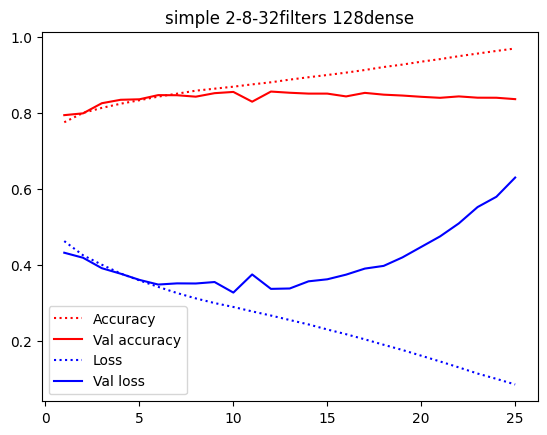

Best accuracy (0.891) at epoch 19


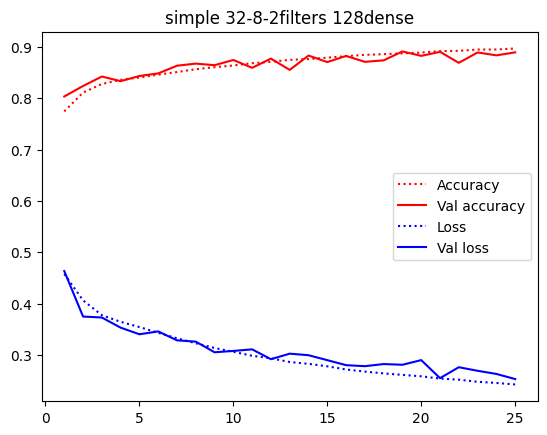

Best accuracy (0.894) at epoch 23


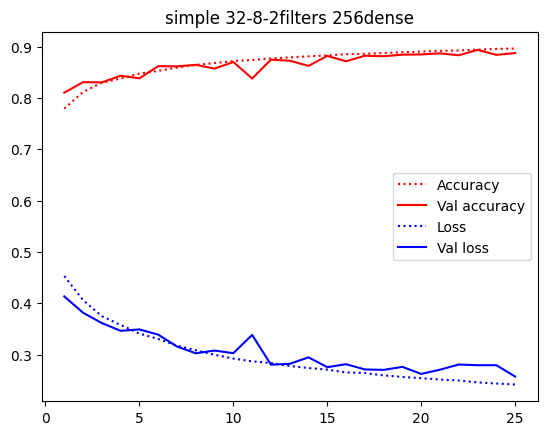

Best accuracy (0.906) at epoch 23


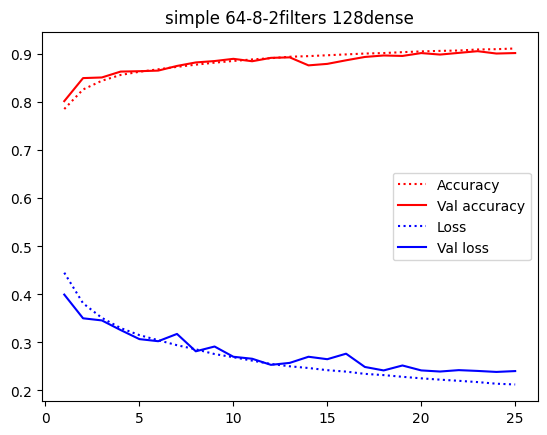

Best accuracy (0.91) at epoch 20


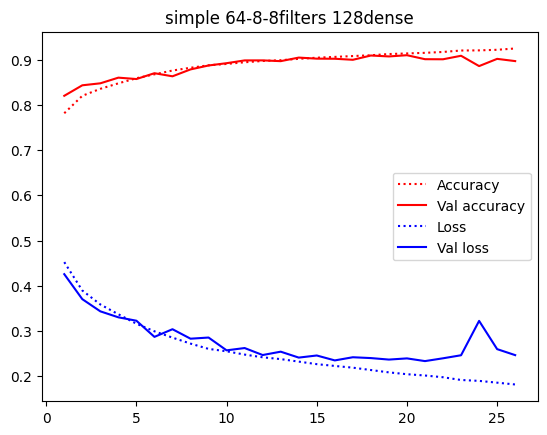

Best accuracy (0.894) at epoch 22


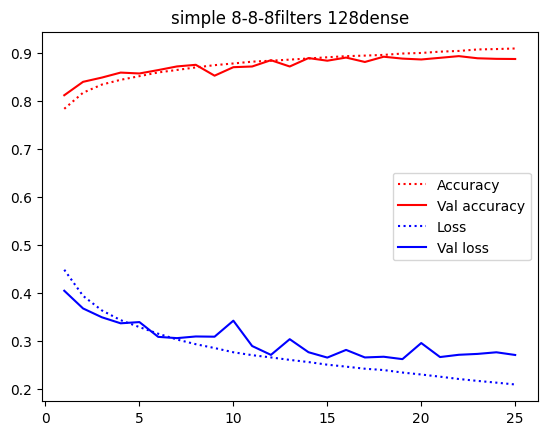

Best accuracy (0.814) at epoch 4


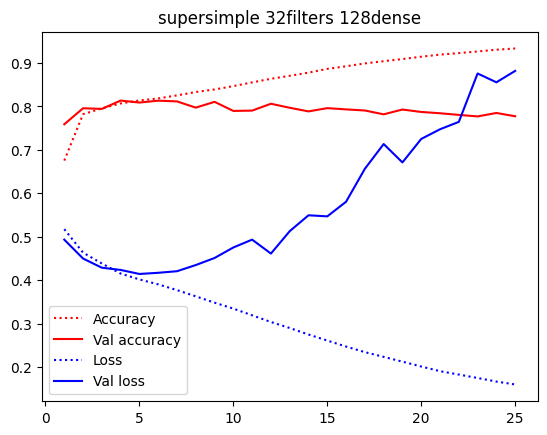

,Model,Best accuracy,Best accuracy epoch
0,supersimple 32filters 128dense,0.813612,4
0,simple 2-8-32filters 128dense,0.856153,12
0,simple 32-8-2filters 128dense,0.891103,19
0,simple 32-8-2filters 256dense,0.893558,23
0,simple 8-8-8filters 128dense,0.894035,22
0,simple 64-8-2filters 128dense,0.906283,23
0,simple 64-8-8filters 128dense,0.909624,20


In [13]:
perf_overview_df = pd.DataFrame()
perf_files = os.listdir("Performance")
perf_df = pd.DataFrame()
for f in perf_files:
    new_df = pd.read_csv(os.path.join('Performance', f))
    model_name = f[0:-4].replace('_',' ')
    new_df['model'] = model_name
    new_df['epoch'] = new_df['Unnamed: 0']+1
    perf_df = pd.concat([perf_df, new_df])
    plt.plot(new_df.epoch, new_df.acc, 'r:')
    plt.plot(new_df.epoch, new_df.val_acc, 'r')
    plt.plot(new_df.epoch, new_df.loss, 'b:')
    plt.plot(new_df.epoch, new_df.val_loss, 'b')
    best_accu = np.max(new_df.val_acc)
    best_epoch = new_df.epoch[np.argmax(new_df.val_acc)]
    print('Best accuracy (' + str(round(best_accu,3)) + ') at epoch ' + str(best_epoch))
    plt.legend(['Accuracy', 'Val accuracy', 'Loss', 'Val loss'])
    plt.title(model_name)
    plt.show()

    perf_overview_df = pd.concat([perf_overview_df, pd.DataFrame([[model_name, best_accu, best_epoch]], columns=['Model', 'Best accuracy', 'Best accuracy epoch'])])
perf_df.drop(columns=['Unnamed: 0'], inplace=True)
perf_df.head()
perf_overview_df.sort_values('Best accuracy')

### Predict individual images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
The image is 3.92% cancer and 96.08% not.


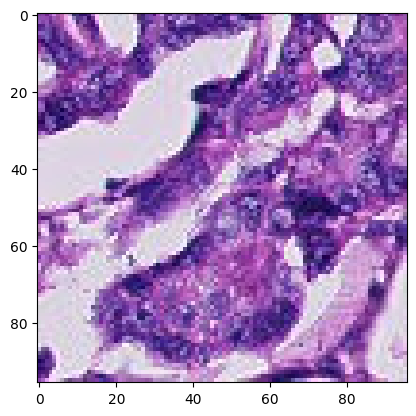

In [21]:
test_file = os.path.join(raw_data_path, 'test', '0000ec92553fda4ce39889f9226ace43cae3364e.tif')
img, img_array = read_pic(test_file)
plt.imshow(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = my_model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"The image is {100 * (1 - score):.2f}% cancer and {100 * score:.2f}% not.")


### Predict all training images

In [11]:
test_files[0]

'00006537328c33e284c973d7b39d340809f7271b.tif'

In [ ]:
test_df = pd.DataFrame(columns=['id','label'])
for i, test_file in enumerate(test_files[0:100]):
    test_df.loc[i,'id'] = test_file[0:-4]
    test_file = os.path.join(raw_data_path, 'test', test_file)
    img, img_array = read_pic(test_file)
    img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

    predictions = my_model.predict(img_array)
    score = float(keras.ops.sigmoid(predictions[0][0]))
    test_df.loc[i,'label'] = int(round(score,0))
test_df.to_csv('submission.csv', index=False)


## Conclusion
*Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?*

Even the simple model yielded reasonable results with validation accuracy better than 0.8. Best performance for the simple model was reached having more filter in the early layers suggesting that the model benefits from putting more weight on the details in the picture. That makes sense since the cancer cells can be as small as single pixel.

Other variables to try could be activation function, batch size, more filter layers, normalization, dropout, etc.

On a personal level, most of the time was spent building the data set which proved challenging without using the pre-built data set tools. I learnt that one needs to pay close attention to the data types (tf.data <--> regular Python data types), running Python functions and making sure the shapes of the variables are correct. Another good practice would be to use a smaller subset of the data and simpler model to verify that the code works before trying to build the actual models.


# Sources
https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

https://keras.io/examples/vision/image_classification_from_scratch/
